# Stellar micro-lensing simulation

In this notebook, we simulate and animate stellar micro-lensing events.
Lentstronomy does not perform any approximations to speed up the calculation and is capable to compute micro-lensing events of arbitrary complexities

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [8]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.psf import PSF
from lenstronomy.Util.util import make_grid
from lenstronomy.Data.pixel_grid import PixelGrid

In [9]:
# define the microlens

# =========
# distances
# =========

d_l = 4000  # distance of the lens in pc
d_s = 8000  # distance of the source in pc
# diameter of milky way 50kpc
# distance from solar to milky way centre 8kpc

# ===========
# lens system
# ===========

M0 = 1e3  # typical mass of IMBH in units of M_sol

# ===========
# source size
# ===========

diameter_s = 1  # size of the radius of the source star in units of the solar radius

In [10]:
# compute lensing properties
from lenstronomy.Cosmo.micro_lensing import einstein_radius, source_size

theta_E = einstein_radius(M0, d_l, d_s)
print(theta_E, 'Einstein radius [arc seconds]')

size_s = source_size(diameter_s, d_s)
print(size_s, 'source size [arc seconds]')

0.03191026155192734 Einstein radius [arc seconds]
1.163118159836867e-06 source size [arc seconds]


In [5]:
# compute ray-tracing grid

grid_scale = size_s / 4.  # ten times the source size resolution
grid_width = theta_E * 4
num_pix = int(grid_width / grid_scale)
print(num_pix)

from lenstronomy.Util import util
x, y = util.make_grid(numPix=num_pix, deltapix=grid_scale)

In [11]:
# map image to source plane
lens = LensModel(lens_model_list=['POINT_MASS'])
kwargs_lens = [{'theta_E': theta_E, 'center_x': 0, 'center_y': 0}]

In [12]:
fwhm = 0.7
deltaPix = 0.2
kwargs_psf = {'psf_type': 'GAUSSIAN',   # type of PSF model (supports 'GAUSSIAN' and 'PIXEL')
              'fwhm': fwhm,             # full width at half maximum of the Gaussian PSF (in angular units)
              'pixel_size': deltaPix    # angular scale of a pixel (required for a Gaussian PSF to translate the FWHM into a pixel scale)
             }
psf = PSF(**kwargs_psf)

In [13]:
num_pix = 30
x0 = make_grid(num_pix, deltaPix)[0][0]
ra_at_xy_0 = dec_at_xy_0 = x0 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': num_pix, 'ny': num_pix,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)

In [14]:
supersampling_factor = 5
kwargs_numerics = {'supersampling_factor': supersampling_factor, # super sampling factor of (partial) high resolution ray-tracing
                        'compute_mode': 'regular', # 'regular' or 'adaptive'
                        'supersampling_convolution': True,  # bool, if True, performs the supersampled convolution (either on regular or adaptive grid)
                        'supersampling_kernel_size': None,  # size of the higher resolution kernel region (can be smaller than the original kernel). None leads to use the full size
                        'flux_evaluate_indexes': None,  # bool mask, if None, it will evaluate all (sub) pixels
                        'supersampled_indexes': None,  # bool mask of pixels to be computed in supersampled grid (only for adaptive mode)
                        'compute_indexes': None,  # bool mask of pixels to be computed the PSF response (flux being added to). Only used for adaptive mode and can be set =likelihood mask.
                        'point_source_supersampling_factor': 1,  # int, supersampling factor when rendering a point source (not used in this script)
                       }

## ELLIPSOID

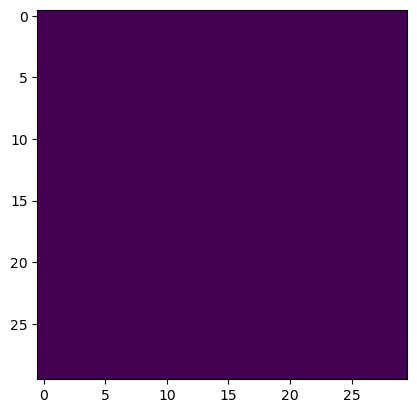

In [9]:
light = LightModel(light_model_list=['ELLIPSOID'])
kwargs_light = [{'amp': 10, 'radius': size_s/2 * 10, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lens,
                                    source_model_class=light,
                                    point_source_class=None, kwargs_numerics=kwargs_numerics)
image = imageModel.image(kwargs_lens = [{'theta_E': theta_E, 'center_x': 0*theta_E, 'center_y': 0}], kwargs_source=kwargs_light)
plt.imshow(image)

## GAUSSIAN

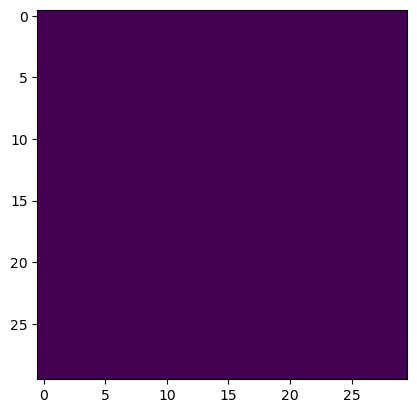

In [10]:
light = LightModel(light_model_list=['GAUSSIAN'])
kwargs_light = [{'amp': 100, 'center_x': 0, 'center_y': 0, 'sigma': size_s/2*10}]
imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lens,
                                    source_model_class=light,
                                    point_source_class=None, kwargs_numerics=kwargs_numerics)
image = imageModel.image(kwargs_lens = [{'theta_E': theta_E, 'center_x': 0, 'center_y': 0}], kwargs_source=kwargs_light)
plt.imshow(image)

## POINT SOURCE

In [16]:
from lenstronomy.PointSource.point_source import PointSource
# unlensed source positon #
point_source_model_list = ['SOURCE_POSITION']
pointSource = PointSource(point_source_type_list=point_source_model_list, lens_model=lens, fixed_magnification_list=[True])
kwargs_ps = [{'ra_source': 0, 'dec_source': 0, 'source_amp': 10}]

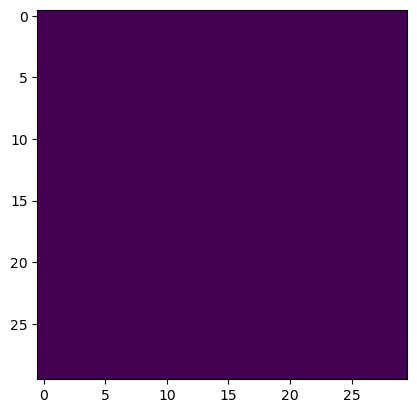

In [17]:
imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lens,
                                    point_source_class=pointSource, kwargs_numerics=kwargs_numerics)
image = imageModel.image(
    kwargs_lens = [{'theta_E': theta_E, 'center_x':0.17086807693848496, 'center_y': 0.026518134537171903}],
    kwargs_ps=[{'ra_source': 0.17218850155442678, 'dec_source': 0.030479408384997367, 'source_amp': 100}])
plt.imshow(image)

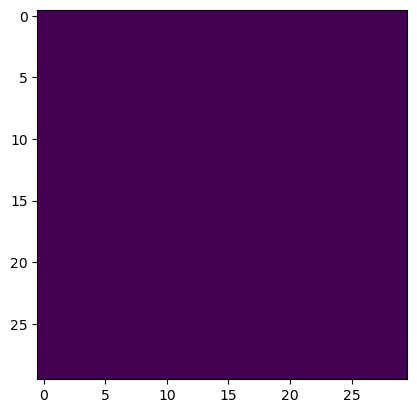

In [15]:
image = imageModel.image(
    kwargs_lens = [{'theta_E': theta_E, 'center_x':-0.001320424615941812, 'center_y': 0.003961273847825464}],
    kwargs_ps=[{'ra_source': 0, 'dec_source': 0, 'source_amp': 100}])
plt.imshow(image)

In [61]:
(imageModel.point_source(kwargs_ps, kwargs_lens)).any()

True

In [22]:
pointSource = PointSource(
    point_source_type_list=point_source_model_list, lens_model=lens, fixed_magnification_list=[True], 
    kwargs_lens_eqn_solver={'search_window': 0.5, 'precision_limit': deltaPix/100})

In [27]:
imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lens,
                                    point_source_class=pointSource, kwargs_numerics=kwargs_numerics)

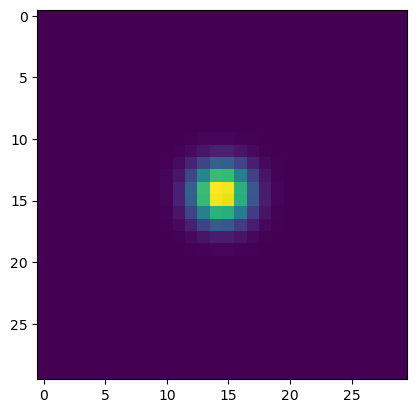

In [71]:
plt.imshow(imageModel.point_source(kwargs_ps, kwargs_lens))

In [28]:
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
lens_solver = LensEquationSolver(lens)

In [29]:
lens_solver.image_position_stochastic(0, 0, kwargs_lens)

(array([-0.02311289,  0.06788468]), array([-0.02919864,  0.08575907]))

In [30]:
lens_solver.image_position_stochastic(0, 0, kwargs_lens, search_window=0.5, num_random=100, precision_limit=deltaPix/100)

(array([-0.02311201,  0.06788384]), array([-0.02919989,  0.08576113]))

In [60]:
lens_solver.image_position_lenstronomy(0, 0, kwargs_lens, search_window=0.5, verbose=True, min_distance=deltaPix/10, precision_limit=deltaPix/100)

There are 2 regions identified that could contain a solution of the lens equation withcoordinates [0. 0.] and [0.   0.14] 
The number of regions that meet the plausibility criteria are 1
Solution found for region 0 with required precision at iteration 1


(array([-0.00048229]), array([-0.00728676]))

In [80]:
pointSource = PointSource(
    point_source_type_list=point_source_model_list, lens_model=lens, fixed_magnification_list=[True],
    kwargs_lens_eqn_solver={'search_window': -x0*2, 'precision_limit': 1e-10, 'min_distance': deltaPix/10})
# kwargs_lens = [{'theta_E': 0.06382052310385468, 'center_x': 0.04477179191557566, 'center_y': 0.05656043420416472}]
# kwargs_ps = [{'ra_source': 0.04279115499166293, 'dec_source': 0.050618523432426524, 'source_amp': 100}]
kwargs_lens = [{'theta_E': theta_E, 'center_x': 0.008698220099428666, 'center_y': 0.13141776783747605}]
kwargs_ps = [{'ra_source': 0.009358432407399576, 'dec_source': 0.12547585706573786, 'source_amp': 100}]

pointSource.image_position(kwargs_ps, kwargs_lens)

([array([0.01256765])], [array([0.09659287])])

In [73]:
from lenstronomy.ImSim.Numerics.point_source_rendering import PointSourceRendering

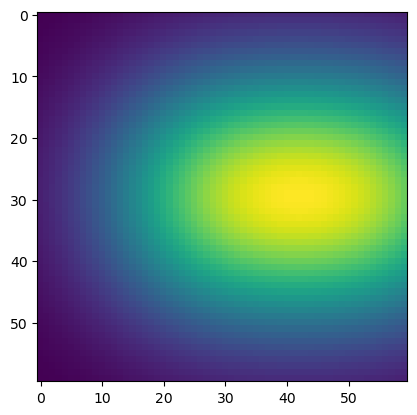

In [78]:
render = PointSourceRendering(pixel_grid, 1, psf)
im = render.point_source_rendering([0,0.5], [0,0], [10,10])
plt.imshow(im)